In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# tỉ lệ 8:2
df = pd.read_csv('F:/hk2 nam3/nhi/is403/IS403_O21_04/Dataset/DXG Historical Data 1_6.csv')
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df[::-1]

df = df.reset_index(drop=True) # Reset the index

In [3]:
# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])

In [5]:
final_model = SimpleExpSmoothing(x_train).fit(optimized=True)
y_pred = final_model.forecast(320)

In [6]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999

In [7]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 15209.653125014902
RMSE: 15508.105289165027
MAPE: 0.9193904068947454


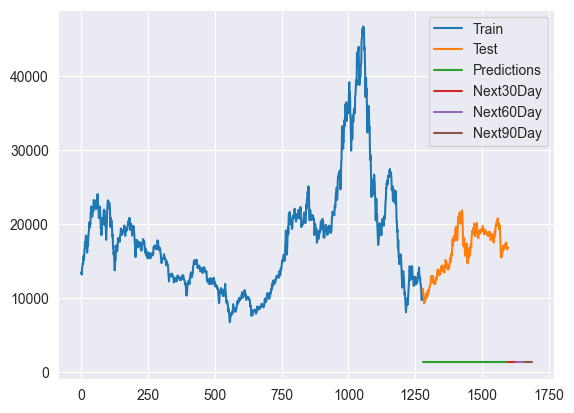

In [8]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [9]:
def plot_model(train, test, y_pred, title):
  mae = mean_absolute_error(test, y_pred)
  train.plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
  test.plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

def des_optimizer(train, test, alphas, betas, trend, step):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)
best_alpha, best_beta, best_mae = des_optimizer(x_train, x_test, alphas, betas, trend='add', step=320)
final_model = ExponentialSmoothing(x_train, trend='add').fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
y_pred = final_model.forecast(320)

In [10]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([1278., 1279., 1280., 1281., 1282., 1283., 1284., 1285., 1286.,
       1287., 1288., 1289., 1290., 1291., 1292., 1293., 1294., 1295.,
       1296., 1297., 1298., 1299., 1300., 1301., 1302., 1303., 1304.,
       1305., 1306., 1307., 1308., 1309., 1310., 1311., 1312., 1313.,
       1314., 1315., 1316., 1317., 1318., 1319., 1320., 1321., 1322.,
       1323., 1324., 1325., 1326., 1327., 1328., 1329., 1330., 1331.,
       1332., 1333., 1334., 1335., 1336., 1337., 1338., 1339., 1340.,
       1341., 1342., 1343., 1344., 1345., 1346., 1347., 1348., 1349.,
       1350., 1351., 1352., 1353., 1354., 1355., 1356., 1357., 1358.,
       1359., 1360., 1361., 1362., 1363., 1364., 1365., 1366., 1367.])

In [11]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 15049.153125
RMSE: 15337.523869072706
MAPE: 0.9102250358014807


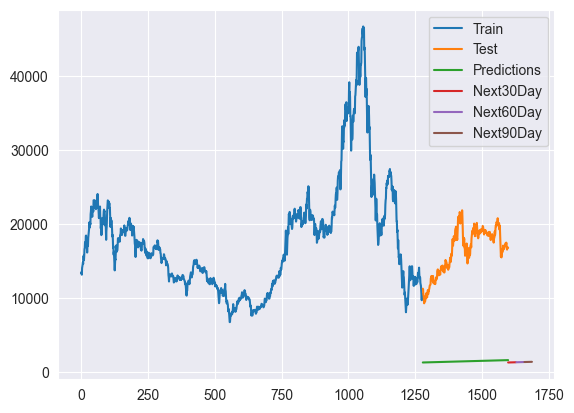

In [12]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [13]:
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        if np.isnan(y_pred).any():
            continue  # Skip this combination if y_pred contains NaN values
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='add', seasonal='add', seasonal_periods=12, step=320)
final_model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(320)



In [14]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([  9068.44448748,   8656.64945151,   8085.75359235,   7260.21003955,
         6671.1207354 ,   6374.30261998,   5849.7875355 ,   5298.58663547,
         4850.67368158,   5034.4447238 ,   4993.87758416,   4083.32794574,
         3279.09424422,   2867.29920825,   2296.40334909,   1470.8597963 ,
          881.77049214,    584.95237672,     60.43729224,   -490.76360779,
         -938.67656168,   -754.90551946,   -795.4726591 ,  -1706.02229752,
        -2510.25599904,  -2922.05103501,  -3492.94689417,  -4318.49044696,
        -4907.57975112,  -5204.39786654,  -5728.91295102,  -6280.11385104,
        -6728.02680493,  -6544.25576271,  -6584.82290236,  -7495.37254078,
        -8299.60624229,  -8711.40127827,  -9282.29713743, -10107.84069022,
       -10696.92999438, -10993.7481098 , -11518.26319428, -12069.4640943 ,
       -12517.37704819, -12333.60600597, -12374.17314562, -13284.72278404,
       -14088.95648555, -14500.75152152, -15071.64738069, -15897.19093348,
       -16486.28023763, -

In [15]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 84435.02590425781
RMSE: 96562.90458248314
MAPE: 4.823202850892621


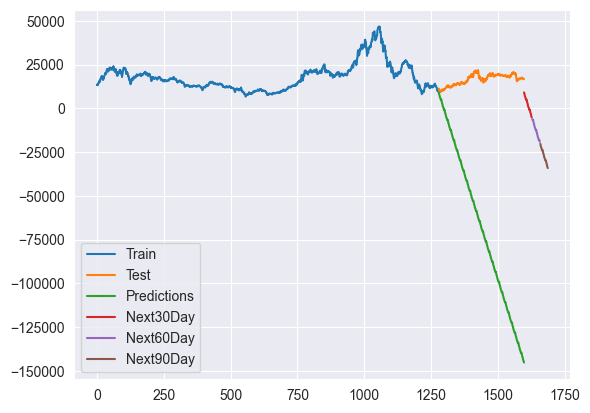

In [16]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [17]:
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        try:
            tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
                fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
            y_pred = tes_model.forecast(step)
            if np.isnan(y_pred).any():
                continue  # Skip this combination if y_pred contains NaN values
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        except ValueError as e:
            if "strictly positive" in str(e):
                continue  # Skip this combination if the error is due to non-positive values
            else:
                raise e

    return best_alpha, best_beta, best_gamma, best_mae


alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='mul', seasonal='mul', seasonal_periods=12, step=320)
final_model = ExponentialSmoothing(y_train, trend='mul', seasonal='mul', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(320)


In [18]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([10339.81104623, 10311.43551219, 10219.54818411, 10144.38664627,
       10105.39381354, 10196.72906396, 10106.81434426, 10072.82707356,
        9874.82043644,  9890.75826016,  9962.99302755,  9935.52252277,
        9731.31511959,  9704.60948036,  9618.12970418,  9547.39140864,
        9510.69329675,  9596.65348494,  9512.03022951,  9480.04310327,
        9293.68911933,  9308.68900514,  9376.67277012,  9350.81889935,
        9158.62906326,  9133.49504587,  9052.10458818,  8985.52922797,
        8950.99079303,  9031.89224038,  8952.24904754,  8922.14435764,
        8746.75727045,  8760.87441581,  8824.85734906,  8800.5249737 ,
        8619.64547317,  8595.99058794,  8519.38994331,  8456.73253047,
        8424.2266759 ,  8500.36708836,  8425.41088238,  8397.07784779,
        8232.01225755,  8245.29861157,  8305.51616129,  8282.61574162,
        8112.38096552,  8090.11816582,  8018.02545465,  7959.05541872,
        7928.46252755,  8000.12209112,  7929.5770437 ,  7902.91140284,
      

In [19]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 11346.719375550358
RMSE: 12445.164472417258
MAPE: 0.6484658841487327


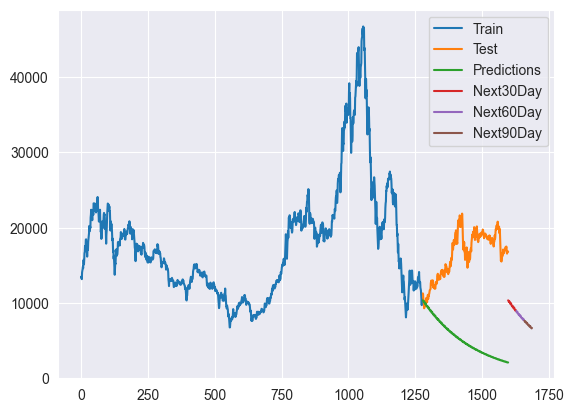

In [20]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [21]:
alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='mul', seasonal='add', seasonal_periods=12, step=320)
final_model = ExponentialSmoothing(y_train, trend='mul', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(320)


In [22]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([10215.76817559, 10215.49594296, 10096.30604525,  9982.76959689,
        9871.16691519,  9965.55423998,  9810.53861695,  9693.94421692,
        9327.91968557,  9459.46018525,  9774.7393889 ,  9875.88115486,
        9533.48195742,  9537.09741691,  9421.77305912,  9312.08012468,
        9204.29905641,  9302.48621894,  9151.24878203,  9038.41103989,
        8676.12176085,  8811.37622923,  9130.34823924,  9235.16176983,
        8896.41341516,  8903.65891478,  8791.94391302,  8685.83976836,
        8581.62704082,  8683.36221155,  8535.65256615,  8426.32251403,
        8067.52093806,  8206.24323646,  8528.66331666,  8636.9052702 ,
        8301.56580321,  8312.20076655,  8203.8559152 ,  8101.10271773,
        8000.22184355,  8105.2698826 ,  7960.85422869,  7854.79939877,
        7499.25438267,  7641.21468493,  7966.85431874,  8078.29748074,
        7746.14098161,  7759.94077613,  7654.74272266,  7555.11839248,
        7457.34855719,  7565.48990833,  7424.14994069,  7321.15327167,
      

In [23]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 11875.000075777003
RMSE: 12972.864956607029
MAPE: 0.6801408305335788


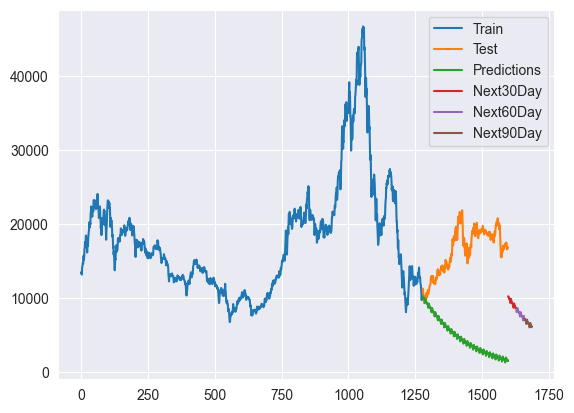

In [24]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [25]:
alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='add', seasonal='mul', seasonal_periods=12, step=320)
final_model = ExponentialSmoothing(y_train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(320)


In [26]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([10353.36761425, 10332.39676789, 10239.18828676, 10152.04447702,
       10089.05116936, 10136.30663911,  9980.23544766,  9873.3338784 ,
        9622.48353089,  9608.48266522,  9673.55944609,  9652.69019456,
        9459.81595544,  9434.19503405,  9342.59410007,  9256.54651435,
        9192.5196083 ,  9228.85606048,  9080.04130084,  8976.03750103,
        8741.31116109,  8721.82616812,  8773.98010671,  8748.04101208,
        8566.26429662,  8535.9933002 ,  8445.99991337,  8361.04855169,
        8295.98804724,  8321.40548184,  8179.84715403,  8078.74112366,
        7860.13879129,  7835.16967103,  7874.40076732,  7843.39182959,
        7672.71263781,  7637.79156636,  7549.40572667,  7465.55058902,
        7399.45648618,  7413.9549032 ,  7279.65300721,  7181.44474629,
        6978.96642148,  6948.51317393,  6974.82142794,  6938.7426471 ,
        6779.160979  ,  6739.58983252,  6652.81153998,  6570.05262636,
        6502.92492512,  6506.50432457,  6379.4588604 ,  6284.14836893,
      

In [27]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 18027.014252976987
RMSE: 20304.422643944497
MAPE: 1.025554906651861


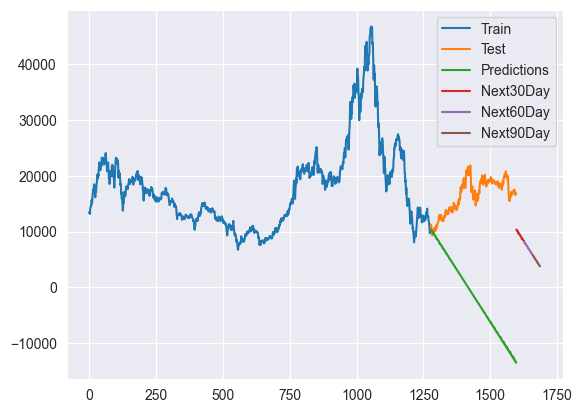

In [28]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

## Observation:
-  Triple Exponential Smoothing with both multiplicative trend and seasonality  acchieve the best MAE, RMSE, MAPE score  -> choose the model